In [1]:
import sys
sys.path.append("../scripts/")
from dijkstra import *
from matplotlib.animation import PillowWriter    #アニメーション保存用

In [2]:
class Astar(Dijkstra):
    def __init__(
        self, world, grid_size_ratio=1,
        drawTakenPath_flag=True, drawCost_flag=False, cost_adj1=15.0, cost_adj2=2.0
    ):
        super().__init__(world, grid_size_ratio, drawTakenPath_flag=drawTakenPath_flag, drawCost_flag=drawCost_flag, cost_adj1=cost_adj1, cost_adj2=cost_adj2)
        self.pp_algorithm_name = "Astar"
    
    def draw(self, ax, elems):
        if not self.isClosed(self.indexWorldToCost(self.world.goal_index)): #ゴールにたどり着いていなければコストを計算
            index, cost = self.expandGrid()    #A*による探索
            self.drawCost(index, cost, ax, elems, self.cost_adj1, self.cost_adj2) if(self.drawCost_flag) else None
        else:
            if self.drawTakenPath_flag is True and self.drawedTakenPath_flag is False:  #経路の描画
                self.getPath()    #経路の算出
                self.drawPath(ax, elems)    #経路の描画
                self.drawedTakenPath_flag = True
                
    def expandGrid(self):
        if len(self.open_list) == 0:
            raise PathNotFoundError("Path was not found")
        val = np.argmin(self.open_list, axis=0) #評価マップの中から最も小さいもの抽出
        grid_id, cost_f, cost_g = self.open_list[val[1]]
        index = np.array([np.where(self.id_map==grid_id)[0][0], np.where(self.id_map==grid_id)[1][0]])
        self.open_list.remove([grid_id, cost_f, cost_g])  #オープンリストから削除
        self.closed_list.append([grid_id, cost_f, cost_g])  #クローズドリストに追加
        self.calculateCost(index, cost_g)    #コストの計算
        return index, cost_f
    
    def calculateCost(self, index, cost_g):   #コストの計算
        for n in self.listFreeNeigbor(index):
            evaluation_f = cost_g + self.cost(n) + self.c(n, index) + self.h(n)   #評価を計算
            if self.isOpened(n): #オープンリストに含まれているか
                its_index, its_cost_f, its_cost_g = self.open_list[[val[0] for val in self.open_list].index(self.id(n))]
                if its_cost_f > evaluation_f: #評価が更新されなければ繰り返しを戻す
                    self.open_list.remove([its_index, its_cost_f, its_cost_g])
                else:
                    continue
            elif self.isClosed(n): #クローズドリストに含まれているか
                its_index, its_cost_f, its_cost_g = self.closed_list[[val[0] for val in self.closed_list].index(self.id(n))]
                if its_cost_f > evaluation_f:
                    self.closed_list.remove([its_index, its_cost_f, its_cost_g])
                else:
                    continue
            self.parent_id_map[n[0]][n[1]] = self.id(index)
            self.open_list.append([self.id(n), evaluation_f, evaluation_f - self.h(n)])
    
    def h(self, u):
        return 0.9 * np.linalg.norm(self.indexWorldToCost(self.world.goal_index) - u)

<IPython.core.display.Javascript object>


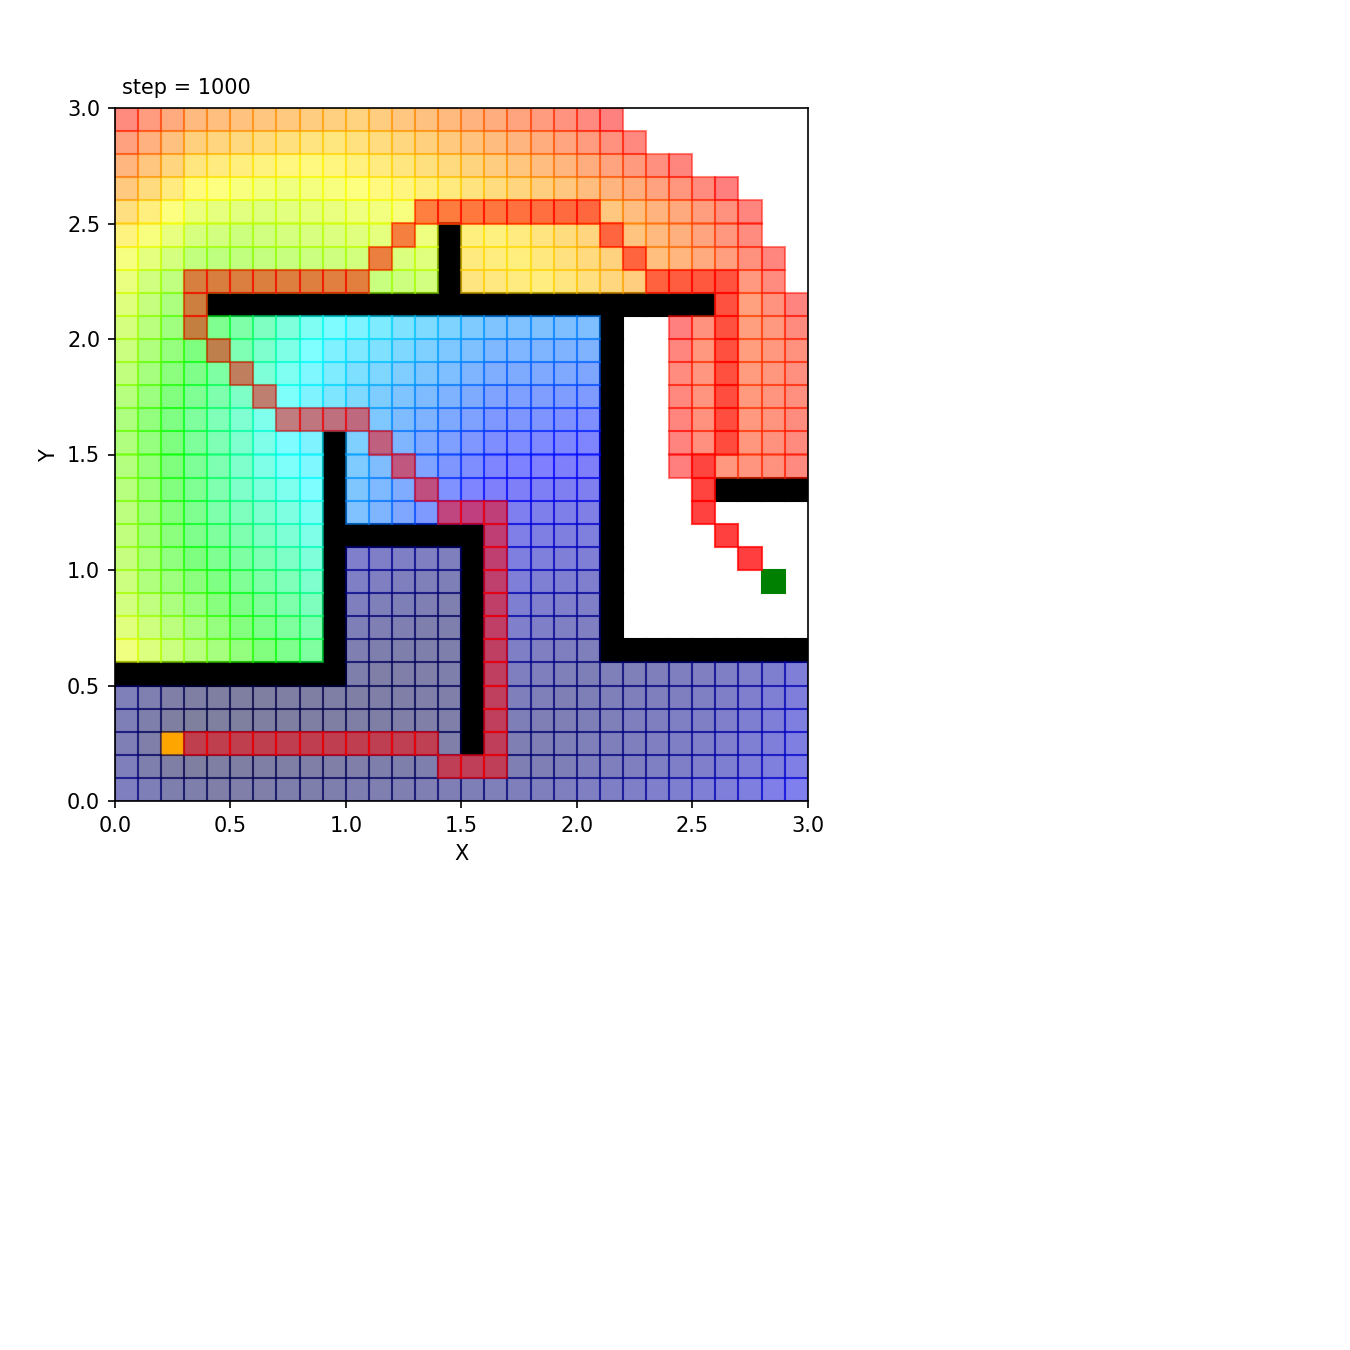

In [3]:
if __name__ == "__main__":
    time_span = 10
    time_interval = 0.01
    
    grid_step = np.array([0.1, 0.1])
    grid_num = np.array([30, 30])
    
    map_data = "../csvmap/map2.csv"
    world = GridMapWorld(grid_step, grid_num, time_span, time_interval, map_data, obstacle_expand=0, debug=False)
    
    #cost_adj1, cost_adj2 = 35.0, 36.35    #map1
    cost_adj1, cost_adj2 = 14.0, 20.0    #map2
    #cost_adj1, cost_adj2 = 3.7, 27.9    #map3
    astar = Astar(world, drawTakenPath_flag=True, drawCost_flag=True, cost_adj1=cost_adj1, cost_adj2=cost_adj2)
    world.append(astar)
    
    world.draw()
    #world.ani.save('astar_map1.gif', writer='pillow', fps=100)    #アニメーション保存